# Art In the Age of Machine Learning

### Forecasting Bar & Restaurant Sales

#### Import Libraries:

In [175]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [176]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [177]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

In [178]:
import requests
import json
from datetime import datetime
import time

In [179]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

from psycopg2.extensions import register_adapter, AsIs

def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)

def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)

from psycopg2.extensions import register_adapter, AsIs

In [180]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 

### Import Custom Modules

In [181]:
from config import yelp_api_key, darksky_api_key, PGHOST, PGDATABASE, PGUSER, PGPASSWORD
from restaurant_info import restaurantLocation
from weather import Weather

### Set Analysis Start Date

In [182]:
raw_date = '2017-01-01' # Start Date Inclusive
start_date = pd.to_datetime(raw_date).date()

### Get Latitude & Longitude from Yelp API

In [183]:
search_business = 'The Counting Room' # Not the actual Restaurant 
location = 'Brooklyn, NY'

In [184]:
# Make Yelp API Call to get Latitude & Longitude for Business
rest_loc = restaurantLocation(search_business, location)
lat, long = rest_loc.get_lat_long()

Weather Location: The Counting Room


### Darksky API Call

In [185]:
# Make Darksky API Call for Date Range as of specific time for given Latitude & Longitude
w_start = start_date
w_end = '2019-06-30'

weather_call = Weather(lat, long,'19:30:00')
#weather_df = weather_call.weather_df(w_start, w_end)

## Start Here -> Import Current Sales  + Weather Data from SQL Database

In [186]:
def import_data():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ PGHOST +" port="+ "5432" +" dbname="+ PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    with psycopg2.connect(conn_string) as conn:

        sales_data = pd.read_sql_query("""SELECT inside.date, inside.inside_sales, outside.outside_sales
                                            FROM 
                                                ( SELECT c.date, SUM(net_sales) inside_sales
                                                  FROM checks c
                                                  JOIN rev_center r
                                                  ON c.rev_center_id = r.id
                                                  WHERE r.name != 'Outside'
                                                  GROUP BY 1 ) inside
                                            LEFT JOIN  
                                                ( SELECT c.date, SUM(net_sales) outside_sales
                                                  FROM checks c
                                                  JOIN rev_center r
                                                  ON c.rev_center_id = r.id
                                                  WHERE r.name = 'Outside'
                                                  GROUP BY 1 ) outside
                                            ON inside.date = outside.date
                                            ORDER BY DATE;""", conn)

        resy_data = pd.read_sql_query("""SELECT *
                                            FROM reservations""", conn)
        
        weather_data = pd.read_sql_query("""SELECT *
                                            FROM weather""", conn)

    current_date = sales_data.date.max()

    return sales_data, resy_data, weather_data, current_date

sales_data, resy_data, weather_data, current_date = import_data()

###  Sales / Resy / Weather Data & Merge

In [213]:
class importMerge:
    
    def __init__(self, sales_file, resy_file, weather_file):
        self.sales_file = sales_file
        self.resy_file = resy_file
        self.weather_file = weather_file
    
    def import_clean_merge(self):
        
        # Read in Sales File
        dfs = self.sales_file.set_index('date')
        
        # Read in Resy File
        dfr = self.resy_file.set_index('date')
        dfr.drop(['id'], axis=1, inplace=True)
        
        # Read in Weather File
        dfw = self.weather_file.set_index('date')
        dfw.drop(['date_id'], axis=1, inplace=True)

        # Filter to target dates
        dfs = dfs[(dfs.index > start_date) & (dfs.index < end_date)]
        dfr = dfr[(dfr.index > start_date) & (dfr.index < end_date)]
        dfw = dfw[(dfw.index > start_date) & (dfw.index < end_date)]

        # Clean Weather File
        dfw['summary'].fillna(value='none', inplace=True)

        # Merge sales, resy and weather csv
        df = pd.merge(dfs, dfr, how='left', on='date')
        df = pd.merge(df, dfw, how='left', on='date')
        df.index = pd.to_datetime(df.index)
        
        # Download to CSV
        df.to_csv(f'csv/rest_1_sales_weather_merged_through_{end_date}.csv')
        df.to_csv('csv/CSV_for_EDA.csv')
        
        return df

### Create Merged DataFrame

In [214]:
merged = importMerge(sales_data, resy_data, weather_data)

In [215]:
df = merged.import_clean_merge()

In [216]:
df.to_csv('csv/CSV_for_EDA_NEW.csv')

In [217]:
df.tail()

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature
date,,,,,,,,,,,,,,,,,,
2019-06-26,12605.00,4487.50,179,67,149,0,97,6,2,84.43,0.43,0.0005,00:00:00,0.00,rain,1015.74,partly-cloudy-day,84.43
2019-06-27,13675.62,5443.00,170,80,143,0,107,5,2,86.09,0.34,0.0001,02:00:00,0.00,none,1019.05,partly-cloudy-day,86.09
2019-06-28,14171.25,6180.50,177,74,145,0,106,12,4,83.09,0.43,0.0000,05:01:00,0.00,none,1019.41,partly-cloudy-day,83.09
2019-06-29,14695.50,5369.75,189,72,135,3,123,10,5,77.17,0.75,0.0571,18:00:00,0.01,rain,1011.84,partly-cloudy-day,76.33
2019-06-30,14073.24,6925.50,221,75,156,2,138,4,1,79.33,0.39,0.0033,16:00:00,0.00,rain,1008.91,partly-cloudy-day,79.33


In [218]:
dep_vars = df[['inside_sales', 'outside_sales', 'inside_covers', 'outside_covers', 'reserved_covers', \
               'walkin_covers', 'waitlist_covers', 'no_show_covers', 'no_show_parties']]

In [219]:
dep_vars.head()

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties
date,,,,,,,,,
2017-01-02,13159.84,NaN,174,0,106,26,42,17,6
2017-01-03,12442.11,NaN,181,0,119,31,31,14,4
2017-01-04,12927.64,NaN,174,0,131,17,26,5,2
2017-01-05,14457.79,NaN,191,0,138,25,28,4,2
2017-01-06,15331.97,NaN,200,0,130,16,54,6,3


In [220]:
indep_vars = df[[var for var in df.columns if var not in dep_vars.columns]]

In [221]:
indep_vars.head()

,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature
date,,,,,,,,,
2017-01-02,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06
2017-01-03,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19
2017-01-04,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29
2017-01-05,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36
2017-01-06,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42


###  Set Up - Variables

In [222]:
end_date = (current_date + pd.DateOffset(1)).date() # Most recent date in Database

target = 'inside_sales'

# Temperature Bins
temp_bins = 4

# Month Clusters
month_clusters = 4

# Outlier Threshold
z_thresh = 2

# Time Range for "Precipitation While Open" Feature
open_time = '05:00PM'
close_time = '11:59PM'

# Windows for Moving Average
trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

# Test / Train / Split
train_date_start = '2017-01-01'
train_date_end = '2018-12-31'

# Closed Days
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-01-01', '2018-02-04', '2019-02-03']

### Construct Training DF

In [223]:
def construct_df(indep_vars, dep_vars, target):
    
    target_df = dep_vars[[target]]
    df = pd.merge(target_df, indep_vars, left_index=True, right_index=True)
    
    return df

df = construct_df(indep_vars, dep_vars, target)

### Correlation Plots Helper Functions

In [224]:
def corr_map(df):

    corr = df.corr()

    # Correlation Map
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
def corr_plots(df):
    
    y = target
    sns.set(style='whitegrid', palette='deep')

    for col in [col for col in df.columns if col != target]:
        try:
            sns.regplot(x=col, y=y, data=df)
            plt.title(f'Correlation between {col} and {target}: {df[y].corr(df[col]):.2f}')
            plt.show();
        except:
            pass

### Transformer to Add Calendar Functions

In [225]:
class CalendarTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, additional_closed_dates):
        self.additional_closed_dates = additional_closed_dates
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        # Add Month
        df['month'] = df.index.month
        
        # Instantiate calendar object
        cal = calendar()
        
        # List of dates with zero sales
        potential_closed_dates = X[X[target] == 0].index
        
        # Assume restaurant is closed when zero sales AND holiday
        # OR when date is in additional closed days list
        X['closed'] = np.where(( ( (X.index.isin(potential_closed_dates) ) & 
                              ( X.index.isin(cal.holidays(start_date, end_date ) ) )) | 
                                X.index.isin(self.additional_closed_dates)), 1, 0)
        
        # Set target to zero when Closed
        X[target] = np.where(X['closed'] == 1, 0, X[target])

        return X

### Transformer to Identify & Impute Outliers

In [226]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, z_thresh):
        self.z_thresh = z_thresh
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
            
        count = 0

        for d in X['day_of_week'].unique():

            # Median / Mean / STD for each day of the week
            daily_median = np.median(X[X['day_of_week'] == d][target])
            daily_mean = np.mean(X[X['day_of_week'] == d][target])
            daily_std = np.std(X[X['day_of_week'] == d][target])

            # Temporary column encoded if Target Columns have an Outlier
            X['temp_col'] = np.where((X['day_of_week'] == d) & 
                                     (X['closed'] == 0) & 
                                     ((np.abs(X[target] - daily_mean)) > (daily_std * self.z_thresh)), 1, 0)

            # Replace Outlier with Mean
            count += np.sum(X['temp_col'])
            X[target] = np.where(X['temp_col'] == 1, daily_mean, X[target])
            X.drop(['temp_col'], axis=1, inplace=True)

        print(f'Outliers imputed - {target}: {count} -> {(count / len(X)*100):.2f}% of total')
            
        return X

### Feature Engineering Transformer

In [227]:
class BasicFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, month_clusters, start_date, end_date):
        self.month_clusters = month_clusters
        self.start_date = start_date
        self.end_date = end_date
        
    def fit(self, X, y = None):

        """ KMeans Month Clusters"""
    
        # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
        describe = X.groupby('month')[target].aggregate(['median', 'std', 'max'])
        temp_df = describe.reset_index()

        # SCALE TEMPORARY DF
        scaler = MinMaxScaler()
        f = scaler.fit_transform(temp_df)

        # INSTANTIATE MODEL
        km = KMeans(n_clusters=self.month_clusters, random_state=0).fit(f)

        # GET KMEANS CLUSTER PREDICTIONS
        labels = km.predict(f)

        # MAKE SERIES FROM PREDICTIONS
        temp_series = pd.DataFrame(labels, columns = ['cluster'], index=temp_df.index)

        # CONCAT CLUSTERS TO DATAFRAME
        temp_df = pd.concat([temp_df, temp_series], axis=1)

        # CREATE CLUSTER DICTIONARY
        temp_dict = {}
        for i in list(X['month']):
            temp_dict[i] = temp_df.loc[temp_df['month'] == i, 'cluster'].iloc[0]
            
        print('Month Clusters: ', temp_dict, '\n', 'Total Clusters: ', len(set(temp_dict.values())))
        
        # CREATE DICTIONARY TO BE ACCESSED IN TRANSFORM
        self.temp_dict = temp_dict
        
        return self
           
    def transform(self, X, y = None):
        
        cal = calendar()
        start_date = pd.to_datetime(self.start_date)
        end_date = pd.to_datetime(self.end_date) + pd.DateOffset(30)
        
        ## ADD MONTHLY CLUSTER FEATURE
        X['month_cluster'] = X['month'].apply(lambda x: self.temp_dict[x]).astype('category')
        X.drop(['month'], axis=1, inplace=True)
        
        # ADD DAY OF WEEK AND MONTH CLUSTER DUMMIES
        X['day_of_week'] = X['day_of_week'].astype('category')
        X = pd.get_dummies(data=X, columns=['day_of_week', 'month_cluster'])
        
        ## TREND FEATURE -> SHORT TERM MOVING AVERAGE OVER LONG TERM MOVING AVERAGE
        X['target_trend'] = X[target].shift(1).rolling(trend_days_rolling).mean() / \
                            X[target].shift(1 + trend_days_shift).rolling(trend_days_rolling).mean()
        
        # THREE DAY WEEKEND FEATURE
        sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
        X['sunday_three_day'] = np.where(X.index.isin(sunday_three_days), 1, 0)
        
        # HOLIDAY
        holiday = [date for date in cal.holidays(start_date, end_date)]
        X['holiday'] = np.where((X.index.isin(holiday)) & (X.closed == 0), 1, 0)
        
        return X

### Transformer to Apply Weather Features

In [228]:
class WeatherFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, temp_bins, open_time, close_time):
        self.temp_bins = temp_bins
        self.open_time = open_time
        self.close_time = close_time
    
    def fit(self, X, y = None):
        return self
    
    # Check if time is during open hours
    def between_time(self, check_time):
        hs_dt = datetime.strptime(self.open_time, "%I:%M%p").time()
        he_dt = datetime.strptime(self.close_time, "%I:%M%p").time()

        if hs_dt <= check_time <= he_dt:
            return 1
        else:
            return 0
    
    def transform(self, X, y = None):
        
        #FIT ONEHOT ENCODER
        temp_enc = KBinsDiscretizer(n_bins=self.temp_bins, encode='onehot', strategy='kmeans')
        temp_enc.fit(X[['apparent_temperature']])
    
        #BIN TEMPERATURES INTO CATEGORIES
        binned_transform = temp_enc.transform(X[['apparent_temperature']])
        binned_df = pd.DataFrame(binned_transform.toarray(), index=X.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot'])
        X = X.merge(binned_df, how='left', on='date')
        
        ## ADD POOR WEATHER FEATURE
        ## IF PRECIP INTENSITY MAX DURING SERVICE, THEN PRECIP WHILE OPEN EQUALS 1
        X['precip_while_open'] = np.where(X['precip_intensity_max'] > 0, X['precip_max_time'].apply(lambda x: self.between_time(x)), 0)
        
        ## DROP UNNECESSARY COLUMNS
        X.drop(['apparent_temperature', 'temperature', 'precip_intensity_max', 'precip_max_time', 
                'summary', 'precip_type', 'pressure'], axis=1, inplace=True)
        
        ## DROP CLOSED DAYS
        X = X[X['closed'] == 0]
        X.drop(['closed'], axis=1, inplace=True)

        return X

### Pipeline Set Up

In [229]:
pre_pipe = Pipeline ( steps = [ ( 'closed' , CalendarTransformer(additional_closed_dates) ),
                                ( 'outliers', OutlierTransformer(z_thresh) ) ] )

post_pipe = Pipeline (steps = [ ( 'basic_features', BasicFeatureTransformer(month_clusters, start_date, end_date) ),
                                ( 'weather_features', WeatherFeatureTransformer(temp_bins, open_time, close_time) ) ] )

### Train / Test / Split Helper Functions

In [230]:
# Drop Target Variable
def drop_target(df):
    
    # Target Variable
    y = df[target][days_fwd:]
    
    # Drop Target
    X = df.drop([target], axis=1)[days_fwd:]

    return X, y

In [231]:
def train_test_split(X, y, train_date_start, train_date_end):
    
    #Split Train & Test based on Date
    X_train = X[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = X[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    #Create DataFrames with proper Column names
    X_train = pd.DataFrame(X_train, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    print(f'Train set: {len(X_train)} -> {len(X_train) / len(X)*100:.2f}%')
    print(f'Test set: {len(X_test)} -> {len(X_test) / len(X)*100:.2f}%')
    
    return X_train, X_test, y_train, y_test

### Scoring Helper Function

In [232]:
def model_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    #RMSE from Sklearn
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Create Prediction DF
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('\n')
    print('Root Mean Squared Error: ', rmse)
    print('Mean Absolute Error: ', mae, '\n')
    
    try:
        print('Intercept:  ', rgr.intercept_, '\n')
        print('Coefficients:  \n')

        for index, col_name in enumerate(X_test.columns):
            print(col_name, ' --> ', rgr.coef_[index])
    except:
        pass
        
    return pred_df

### Feature Importance - Helper Function

In [233]:
def feature_importance(rgr, X_train, y_train):
    
    features = list(X_train.columns)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()

    labels = list(map(lambda x: x.title(), features))
    visualizer = FeatureImportances(rgr, ax=ax, labels=labels, relative=False)

    visualizer.fit(X_train, y_train)
    visualizer.poof();

### Residual Plot - Helper Function

In [234]:
def residual_plot(rgr, X_train, y_train, X_test, y_test):

    plt.figure(figsize=(12,8))

    visualizer = ResidualsPlot(rgr, hist=False)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof();

### Reset DataFrame:

In [235]:
df = construct_df(indep_vars, dep_vars, target)

### Baseline Linear Regression

In [236]:
def baseline(df, pre_pipe):
    
    # Add Missing Columns
    df['day_of_week'] = df.index.dayofweek.astype('category')
    
    # Drop Weather Columns
    df = df.drop(['apparent_temperature', 'humidity', 'precip_intensity_max', 'precip_max_time', \
                  'precip_prob', 'precip_type', 'pressure', 'summary', 'temperature'], axis=1)
   
    # Basic Transformations
    df = pre_pipe.fit_transform(df)
    df = pd.get_dummies(data=df, columns=['day_of_week'])
    
    # Drop Closed Days
    df = df[df['closed'] == 0]
    df.drop(['closed'], axis=1, inplace=True)
    
    # Separate Target & Features
    X, y = drop_target(df)
    
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_date_start, train_date_end)
    
     # Fit a Lasso Regression Model
    linearReg = LinearRegression(fit_intercept=True)
    linear_rgr = linearReg.fit(X_train,y_train)
    
    # Run Regression Scoring Helper Function
    pred_df = model_score(linear_rgr, X_train, y_train, X_test, y_test, X, y)

    return pred_df, y_test, X_train

baseline_pred_df, baseline_y_test, baseline_X_train = baseline(df, pre_pipe)

Outliers imputed - inside_sales: 30 -> 3.34% of total
Train set: 682 -> 79.21%
Test set: 179 -> 20.79%


Root Mean Squared Error:  1293.5907155026905
Mean Absolute Error:  973.1466096788417 

Intercept:   14384.427265788927 

Coefficients:  

day_of_week_0  -->  -834.3285206717393
day_of_week_1  -->  -1128.042917855856
day_of_week_2  -->  -578.9967816883077
day_of_week_3  -->  -235.3137549964009
day_of_week_4  -->  1023.7219144752543
day_of_week_5  -->  1989.317784716125
day_of_week_6  -->  -236.35772397907544


### Linear Regression "Pipeline"

Outliers imputed - inside_sales: 30 -> 3.34% of total
Month Clusters:  {1: 3, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2} 
 Total Clusters:  4
Train set: 682 -> 79.21%
Test set: 179 -> 20.79%


Root Mean Squared Error:  1214.8509812056082
Mean Absolute Error:  893.4172484089822 

Intercept:   14112.865036701882 

Coefficients:  

humidity  -->  0.0
precip_prob  -->  -0.0
day_of_week_0  -->  -440.0276546500231
day_of_week_1  -->  -709.7870089815215
day_of_week_2  -->  -173.46210399545535
day_of_week_3  -->  122.80630010697665
day_of_week_4  -->  1404.0822204111057
day_of_week_5  -->  2320.674515085374
day_of_week_6  -->  -0.0
month_cluster_0  -->  151.5708853123947
month_cluster_1  -->  -129.21184771106914
month_cluster_2  -->  260.748768662231
month_cluster_3  -->  -419.1313399671824
target_trend  -->  0.0
sunday_three_day  -->  934.9986832365827
holiday  -->  -273.7554435546863
temp_very_cold  -->  -0.4629462816930545
temp_cold  -->  167.38870269329473
temp_wa

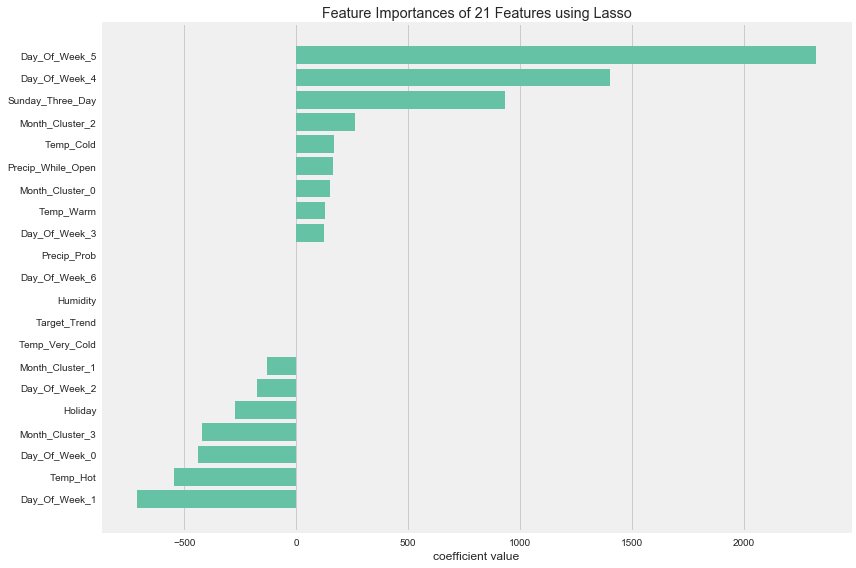

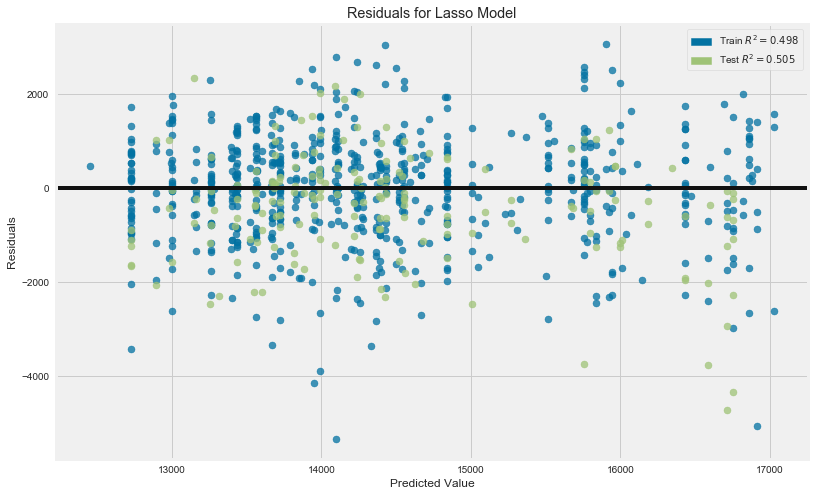

In [237]:
def run_linear(df, pre_pipe, post_pipe):

    # Pre Processing Pipeline
    df = pre_pipe.fit_transform(df)
    
    # Feature Engineering Pipeline
    df = post_pipe.fit_transform(df)
    
    # Separate Target & Features
    X, y = drop_target(df)
    
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_date_start, train_date_end)
    
    # Fit a Lasso Regression Model
    lassoReg = Lasso(fit_intercept=True, alpha=1)
    lasso_rgr = lassoReg.fit(X_train,y_train)
    
    # Run Regression Scoring Helper Function
    pred_df = model_score(lasso_rgr, X_train, y_train, X_test, y_test, X, y)
    
     # Feature Importance Chart
    feature_importance(lasso_rgr, X_train, y_train)
    
    # Residual Chart
    residual_plot(lasso_rgr, X_train, y_train, X_test, y_test)
    
    return pred_df, y_test, X_train
    
pred_df, y_test, X_train = run_linear(df, pre_pipe, post_pipe)

## Run XGB Regressor "Pipeline"

Outliers imputed - inside_sales: 25 -> 2.75% of total
Month Clusters:  {1: 3, 2: 3, 3: 2, 4: 2, 5: 2, 6: 0, 7: 2, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  4
Train set: 683 -> 79.23%
Test set: 179 -> 20.77%
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.1min finished


Grid Search:  XGBRegressor 

Grid Search Best Score:  -1164796.0181360678
Grid Search Best Params:  {'colsample_bytree': 0.775, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'min_impurity_decrease': 0.0001, 'n_estimators': 275}
Grid Search Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.775, gamma=0, importance_type='gain',
             learning_rate=0.02, max_delta_step=0, max_depth=3,
             min_child_weight=2, min_impurity_decrease=0.0001, missing=None,
             n_estimators=275, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=1)


Root Mean Squared Error:  1075.8249194333362
Mean Absolute Error:  834.7026544417437 



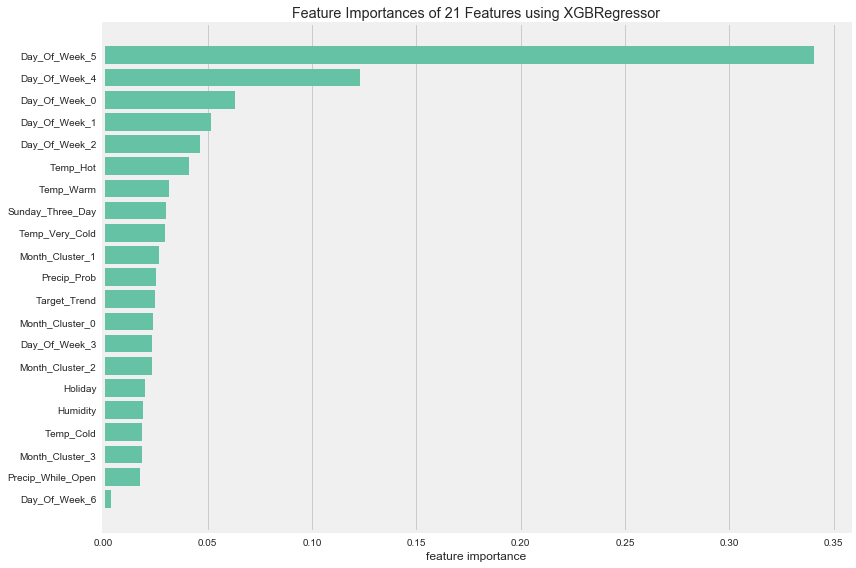

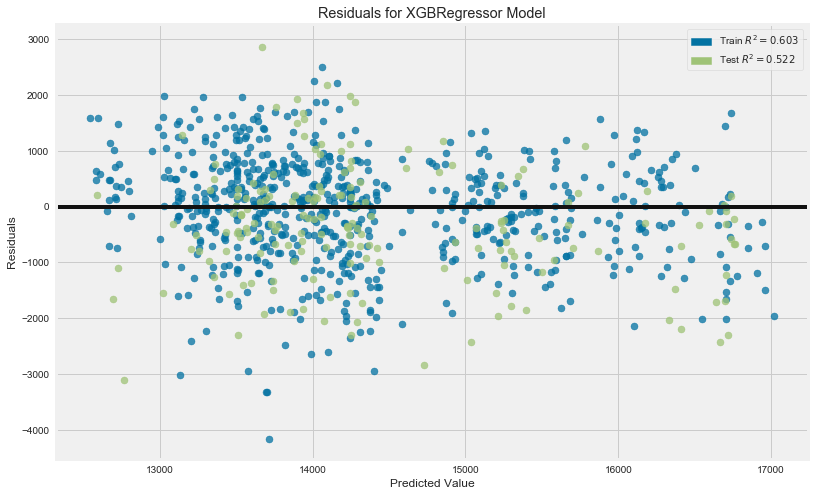

In [147]:
params = {
          'learning_rate': [0.0175, 0.02, 0.0225],
          'max_depth': [3, 4, 5],
          'min_impurity_decrease': [0.0001, 0.0001],
          'colsample_bytree': [0.775,0.80, 0.825],
          'n_estimators': [250, 275, 300],
          'min_child_weight': [2]
        }

def run_xgb(df, pre_pipe, post_pipe, params):

    # Pre Processing Pipeline
    df = pre_pipe.fit_transform(df)
    
    # Feature Engineering Pipeline
    df = post_pipe.fit_transform(df)
    
    # Separate Target & Features
    X, y = drop_target(df)
    
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_date_start, train_date_end)

    # Instantiate XGB Regressor object
    rgr = XGBRegressor(booster='gbtree', objective='reg:linear', random_state = 0)
    
    # Scoring attribute for Grid Search
    scoring = 'neg_mean_squared_error'
    
    # Instantiate & Fit Grid Search Object
    grid = GridSearchCV(rgr, params, cv=5, n_jobs=-1, scoring=scoring, verbose=5)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)
    
    # Run Regression Scoring Helper Function
    pred_df = model_score(best_grid_rgr, X_train, y_train, X_test, y_test, X, y)

    # Feature Importance Chart
    feature_importance(best_grid_rgr, X_train, y_train)
    
    # Residual Chart
    residual_plot(best_grid_rgr, X_train, y_train, X_test, y_test)
    
    return pred_df, y_test, best_grid_rgr, X_train, X, y

pred_df, y_test, best_grid_rgr, X_train, X, y = run_xgb(df, pre_pipe, post_pipe, params)

## Evaluation - Actual Sales vs. Predicted

In [148]:
data = df.rename(columns={target: f'true_{target}'})
pred_df = pred_df.rename(columns={target: f'pred_{target}'})

eval_df = pred_df.merge(data, on='date', how='inner')

eval_df['mape'] = np.where(eval_df[f'true_{target}'] > 0, np.abs(eval_df[f'true_{target}'] - eval_df[f'pred_{target}']) / eval_df[f'true_{target}'], 0)
eval_df['absolute_error'] = np.abs(eval_df[f'true_{target}'] - eval_df[f'pred_{target}'])

print('Mean Absolute Error by Day:')
eval_df.groupby('day_of_week')['absolute_error'].aggregate(['mean', 'std'])

print(f'Mean Absolute Error: ${eval_df.absolute_error.sum() / len(eval_df.absolute_error):.2f}', '\n')

print(f'Mean Absolute Percentage Error: {eval_df.mape.mean() * 100:.2f}%', '\n')

print('--------', '\n', 'Highest Absolute Errors by Day:')
eval_df.loc[eval_df.groupby(['day_of_week'])['mape'].idxmax()][['day_of_week', 'mape', 'absolute_error', f'pred_{target}', f'true_{target}', ]]


Mean Absolute Error by Day:


,mean,std
day_of_week,,
0,728.646372,587.162877
1,874.473791,841.612602
2,817.042060,615.273489
3,781.255442,584.142775
4,881.368054,592.964148
5,873.190338,768.010082
6,886.380714,792.952196


Mean Absolute Error: $834.70 

Mean Absolute Percentage Error: 5.60% 

-------- 
 Highest Absolute Errors by Day:


,day_of_week,mape,absolute_error,pred_inside_sales,true_inside_sales
date,,,,,
2019-01-21,0,0.161174,1928.815430,13896.065430,11967.25
2019-01-08,1,0.264355,2858.021797,13669.341797,10811.32
2019-03-06,2,0.181992,2170.282148,14095.452148,11925.17
2019-05-02,3,0.138837,2297.230703,14249.029297,16546.26
2019-05-17,4,0.139251,2432.011484,15032.978516,17464.99
2019-03-02,5,0.127052,2425.866875,16667.703125,19093.57
2019-05-12,6,0.161577,1981.354336,14243.944336,12262.59


In [149]:
def predict_one(rgr, X, y, end_date):

    date_1 = pd.to_datetime(end_date) + pd.DateOffset(-days_fwd)
    date_2 = pd.to_datetime(end_date)
     
    # Pull Weather Data / Forecast
    weather_df = weather_call.weather_df(date_1, date_2)
    
    # Add Sales Data for Sales Trend Engineering
    df = pd.merge(weather_df, y, on='date', how='left')
    
    # Add Closed Variable
    df['closed'] = 0
    
    # Add Feature Engineering
    df['precip_max_time'] = df['precip_max_time'].apply(lambda x: pd.to_datetime(x).time())
    df = post_pipe.transform(df)
    
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X.columns][-1:]
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(rgr.predict(df), index=df.index, columns=[target])
    pred_df = pred_array.merge(df, on='date', how='left')
    
    return pred_df

In [155]:
predict_date = '2019-07-01'

tonight = predict_one(best_grid_rgr, X, y, predict_date)
tonight[target].T

date
2019-07-01    13191.470703
Name: inside_sales, dtype: float32

### Predict Upcoming Week

In [156]:
def predict_multiple(rgr, X, y, start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))

    temp_y = y
    temp_df = pd.concat([X, y], axis=1)
    
    for day in list_of_days:
        
        new_prediction = predict_one(rgr, X, temp_y, day)
        temp_df = pd.concat([temp_df, new_prediction])
        temp_y = pd.concat([temp_y, new_prediction[target]])
    
    # Rename Column to 'sales'
    temp_df = temp_df.rename(columns={target: f'{target}_predictions'})
    
    return temp_df

upcoming_df = predict_multiple(best_grid_rgr, X_train, y, '2019-07-01', '2019-07-07')

In [157]:
upcoming_df[-7:][[f'{target}_predictions', 'holiday', 'humidity', 'precip_prob', 'precip_while_open', 'target_trend']]

,inside_sales_predictions,holiday,humidity,precip_prob,precip_while_open,target_trend
date,,,,,,
2019-07-01,13191.470703,0.0,0.38,0.00,0.0,0.983097
2019-07-02,12730.857422,0.0,0.57,0.00,1.0,0.982569
2019-07-03,13375.191406,0.0,0.60,0.00,0.0,0.977318
2019-07-04,13481.114258,1.0,0.67,0.00,0.0,0.978216
2019-07-05,15225.776367,0.0,0.85,0.00,1.0,0.981157
2019-07-06,16289.688477,0.0,0.79,0.44,1.0,0.982423
2019-07-07,14202.731445,0.0,0.63,0.00,0.0,0.988668


In [153]:
np.sum(upcoming_df[-7:][f'{target}_predictions'])

98496.830078125

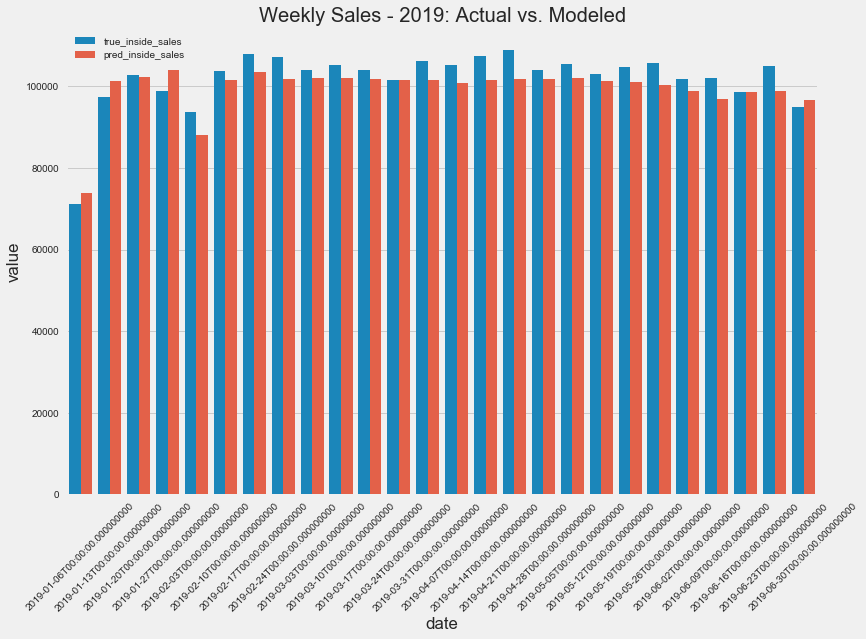

In [154]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(12,8))

eval_df_weekly = eval_df[[f'true_{target}', f'pred_{target}']]['2019'].resample('W').sum()
ew = pd.melt(eval_df_weekly.reset_index(), id_vars='date')

sns.barplot(x = 'date', y = 'value', hue = 'variable', data = ew)

plt.title('Weekly Sales - 2019: Actual vs. Modeled')
plt.legend(loc = 'upper left')
plt.xticks(rotation=45)

plt.show();